In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Pose Estimation

**This pose estimamtion task or the measurement model is the same as the one in the previous assignment.**


**While doing the pose estimation we need to first generate the world coordinates, According to the image provided and the parameters file provide we calculate the tag corner positions as per the real world.  Th below function acconts for the odd spacing in the 3rd and 6th colums. Using simple math we obtain the four corner point for each tag. The function takes in the tag ids and calculates the respective corners for each tag.**

In [2]:
import scipy.io
import cv2
import numpy as np

def get_world_coordinates(tag_ids):
    # Define dimensions of the tags and grid
    tag_width = 0.152  # meters
    tag_spacing_horizontal = [0, 0.152, 0.152, 0.178, 0.152, 0.152, 0.178, 0.152, 0.152]
    tag_spacing_vertical = 0.152  # meters
    rows, cols = 12, 9

    # Initialize a list to store world coordinates as tuples
    world_coordinates = []

    for tag_id in tag_ids:
        # Calculate tag position in the grid
        row = tag_id % rows
        col = tag_id // rows

        # Calculate x, y, and z coordinates for each corner of the tag
        x_offset = tag_spacing_vertical * row
        y_offset = sum(tag_spacing_horizontal[:col + 1])

        # # Define corner coordinates in the local tag frame
        corners_local = np.array(
            [
                [row * tag_width + 0, col * tag_width + 0, 0.0],
                [row * tag_width + tag_width, col * tag_width + 0, 0.0],
                [row * tag_width + tag_width, col * tag_width + tag_width, 0.0],
                [row * tag_width + 0, col * tag_width + tag_width, 0.0],
            ]
        )

        # Transform local coordinates to world coordinates
        corners_world = corners_local + np.array([x_offset, y_offset, 0.0])
        # Append the tuple of 3D points for the current tag
        world_coordinates.extend(map(tuple, corners_world))

    return world_coordinates



After writing the code for obtaining the world co-ordinates, We extrat the given image 2D corners and then obtain the repective 3D world points.

The camera calibration matrix can be represented as:

$\mathbf{Camera\_Matrix} = \begin{bmatrix}
314.1779 & 0 & 199.4848 \\
0 & 314.2218 & 113.7838 \\
0 & 0 & 1 \\
\end{bmatrix}$

The distortion coefficients can be represented as:

$\mathbf{Dist\_Coeffs} = \begin{bmatrix}
-0.438607 & 0.248625 & 0.00072 & -0.000476 & -0.0911 \\
\end{bmatrix}$


To solve for the 6 DOF pose of the camera (its rotation and translation with respect to the world), we can use the perspective projection model for cameras. Given a set of n 3D points in a world reference frame and their corresponding 2D image projections, as well as the calibrated intrinsic camera parameters, we want to determine the rotation matrix  R and translation vector T.
The perspective projection model equation can be represented as:

$\mathbf{M} = \begin{bmatrix}
f_{x} & \gamma & u_{0} & t_{1} \\
0 & f_{y} & v_{0} & t_{2} \\
0 & 0 & 1 & t_{3}
\end{bmatrix}
\begin{bmatrix}
r_{11} & r_{12} & r_{13} & t_{1} \\
r_{21} & r_{22} & r_{23} & t_{2} \\
r_{31} & r_{32} & r_{33} & t_{3}
\end{bmatrix}
\begin{bmatrix}
x \\ y \\ z \\ 1
\end{bmatrix}$

Where:
- $\mathbf{M}$ represents the perspective projection model equation.
- $\mathbf{K}$ is the camera matrix with intrinsic parameters.
- $\mathbf{R}$ is the rotation matrix.
- $\mathbf{T}$ is the translation vector.
- $f_{x}$ and $f_{y}$ are the scaled focal lengths.
- $\gamma$ is the skew parameter.
- $(u_{0}, v_{0})$ is the principal point.
- $(x, y, z)$ are the coordinates of the 3D world point.

Now we use the Solve pnp function that return the rotation vector and the translation vector. Later the rotation matrix obtain by using the rodrigues formula to convert rotation vector to rotation matrix. Later, this rotation matrix and translation vector is combined to create a transforamtion matrix. This matrix in the tranformation of camera to world. Further we have information provided for the yaw rotated with pi/4, and the roll of pi are used for the transformation between the Camera frame to the IMU frame (Robot Frame) and generate a tranformation matrix.

$${T{w,r} = T{w,c} + T{c,r}}$$

We extract the translation and rotation matrxi from this tranformation. We extrac the euler angles from the rotation matrix and return the position, orientation of the observation model

In [3]:
import scipy.io
import cv2
import numpy as np
from scipy.spatial.transform import Rotation
def estimate_pose(data):

  # print("estimating pose")
  # Extract the image corner points
  p1, p2, p3, p4 = data['p4'], data['p1'], data['p2'], data['p3']
  # extracting the tag id array
  tag_ids =data['id']
  timestamp=[]

  # if the tag id is int convert it into an array and reshape the image data point into a 2x1 array
  if isinstance(tag_ids, int):
    tag_ids=np.array([tag_ids])
    p1=p1.reshape(2,1)
    p2=p2.reshape(2,1)
    p3=p3.reshape(2,1)
    p4=p4.reshape(2,1)


  #If the lent of the tag id is zero that means it does not see anything then just return 0 orientation and 0 position
  if(len(tag_ids)==0):
    position=np.nan
    orientation=np.nan
    timestamp = np.nan
    return position, orientation ,timestamp

  # Arrange the image points as the world points are extracted from the tag id so that the
  image_points = []
  for i in range(p1.shape[1]):
    image_points.append((p1[0, i], p1[1, i]))
    image_points.append((p2[0, i], p2[1, i]))
    image_points.append((p3[0, i], p3[1, i]))
    image_points.append((p4[0, i], p4[1, i]))


  world_points = get_world_coordinates(tag_ids)
  num_world_points = len(world_points)
  num_image_points = len(image_points)

  world_points=np.array(world_points)
  image_points=np.array(image_points)

  # Camera calibration matrix
  camera_matrix = np.array([[314.1779 , 0 , 199.4848],
                            [0 , 314.2218 , 113.7838],
                            [0, 0, 1]])

  # Distortion coefficients
  dist_coeffs = np.array([-0.438607, 0.248625, 0.00072, -0.000476, -0.0911])

  # Solve PnP problem
  success, rotation_vector, translation_vector = cv2.solvePnP(world_points, image_points, camera_matrix, dist_coeffs)

  # Convert rotation vector to rotation matrix
  rotation_matrix, _ = cv2.Rodrigues(rotation_vector)

  # Create a 4x4 transformation matrix
  transformation_matrix_camera_to_world = np.eye(4)  # Identity matrix

  # Fill the upper-left 3x3 submatrix with the rotation matrix
  transformation_matrix_camera_to_world[:3, :3] = rotation_matrix

  # Fill the last column with the translation vector
  transformation_matrix_camera_to_world[:3, 3] = translation_vector.squeeze()

  # Accounting for the yaw and roll for the axis in camera and imu
  shifted_yaw =  - np.pi / 4
  shifted_roll = np.pi

  # Create a homogeneous transformation matrix from provided shift in XYZ and yaw
  shift_xyz_yaw = np.array([[np.cos(shifted_yaw), -np.sin(shifted_yaw), 0, -0.04],
                              [np.sin(shifted_yaw), np.cos(shifted_yaw), 0, 0.0],
                              [0, 0, 1, -0.03],
                              [0, 0, 0, 1]])

  roll_rotation_matrix = np.array([[1, 0, 0, 0],
                              [0, np.cos(shifted_roll), -np.sin(shifted_roll), 0],
                              [0, np.sin(shifted_roll), np.cos(shifted_roll), 0.0],
                              [0, 0, 0, 1]])


  transformation_from_robot_to_camera= shift_xyz_yaw @ roll_rotation_matrix

  # Final transformation from world to robot
  tranformatin_from_world_to_robot= np.linalg.inv(transformation_matrix_camera_to_world) @ transformation_from_robot_to_camera

  # Obtaining the final rotaion matrix and extracting euler angles from it and obtaining positions
  final_rotation_matrix= tranformatin_from_world_to_robot[:3, :3]
  position = tranformatin_from_world_to_robot[:3, 3]
  r = Rotation.from_matrix(final_rotation_matrix)
  roll, pitch, yaw = r.as_euler('xyz')
  orientation = np.array([roll, pitch, yaw])

  # Obtaining timestamps
  timestamp = data['t']

  return position, orientation, timestamp

#Task 1 : Implementation

# Particle Filter

The first step for the particle filter is to generate the particle. Given the input size of the particle, I have generated a matrix of size `(number of particles, 15)`. Further, I have set up the range for the `x`, `y`, and `z` coordinates between `0` to `3`, and `0` to `2` for the `z` coordinate as observed from the measurement model graphs. For the roll, pitch, and yaw angles, we set up the range from $-\frac{\pi}{2}$ to $\frac{\pi}{2}$. The velocities and the biases are defined by a uniform distribution from `-0.5` to `0.5`.


## Prediction Step

In the second step, we predict for each state and all the particles created in that state. Here, as advised in the assignment, I have utilized matrix multiplication rather than a for loop in order to reduce computational time. Also, as guided in the assignment, I have added noise to the control inputs provided. Further, the $Gq_{\text{inv}}$ and $Rq$ values are calculated as matrices, and we can see that in one matrix multiplication, we can calculate $\dot{x}$ for all the particles for the single state. Later, I have also added noise with covariance matrix $Q$ in the $\dot{x}$ and predicted the next state as follows:


$$ x_{\text{next}} = x_{\text{prev}} + (\dot{x} + \text{noise}) \times dt $$


The noise covariance matrix $Q$ is defined as:


$$ Q = \text{np.diag}([0.01] \times 3 + [0.01] \times 3 + [0.01] \times 3 + [0.001] \times 3 + [0.001] \times 3) \times 450 $$

I have tuned the $Q$ matrix as follows: increasing the noise values more than this makes the results go weird, and the RMSE increases quickly as the path deviates from the estimated track. At the same time, lowering the values can cause NaN values while calculating the weights, so it has to be tuned to these values. If observed, we provide equal weightage to the position, angles, and velocities, whereas a lesser weightage to the biases.

## Weight Calculation and Update Step

For obtaining the weights and the update step, we calculate the error between the measurement $z$ and the predicted particles. This error is projected into a Gaussian function to calculate the weights. Later in the update function, we adjust the weights by the highest index and compute a weighted average of the particles and the weights. This uses the mean methods as suggested by the assignment and returns the estimated states.

In this step, we use the same covariance matrix as calculated in the last assignment. The only difference here is that the diagonal elements are kept intact and other elements are set to zero:

$$ \mathbf{R} = \text{np.diag}([0.00669, 0.00484, 0.00881, 0.00412, 0.00638, 0.00110]) $$

## Low Variance Resampling

Further, I have also implemented the low variance resampling, which is exactly as provided in the lecture slides.


In [4]:
import numpy as np
import scipy.io
import sympy as sp

class ParticleFilter:
  def __init__(self, num_particles,mat_file):
      self.mat_file = mat_file
      self.num_particles = num_particles

      self.R  = np.diag([0.00669, 0.00484, 0.00881, 0.00412, 0.00638, 0.00110])
    #   self.R = np.array([
    # [6.66963921e-03, 5.38548767e-05, 1.63620113e-03, 1.67040857e-05, 4.10176940e-03, 7.35551995e-04],
    # [5.38548767e-05, 4.48424965e-03, -1.31399330e-03, -3.58369361e-03, 8.33674635e-04, -6.79055429e-05],
    # [1.63620113e-03, -1.31399330e-03, 8.81311935e-03, 1.41573427e-03, 2.83727856e-03, -1.02644087e-03],
    # [1.67040857e-05, -3.58369361e-03, 1.41573427e-03, 4.11917161e-03, 3.35394858e-04, -4.47555569e-04],
    # [4.10176940e-03, 8.33674635e-04, 2.83727856e-03, 3.35394858e-04, 6.38801706e-03, -1.14463037e-03],
    # [7.35551995e-04, -6.79055429e-05, -1.02644087e-03, -4.47555569e-04, -1.14463037e-03, 1.10043447e-03]])

      self.Q = np.diag([0.01] * 3 + [0.01] * 3 + [0.01] * 3 + [0.001] * 3 + [0.001] * 3) * 450

      mat_data = scipy.io.loadmat(self.mat_file, simplify_cells=True)
      self.data= mat_data["data"]

      self.average_filtered_positions = []
      self.average_filtered_orientations = []
      self.highest_filtered_positions = []
      self.highest_filtered_orientations = []
      self.weighted_average_filtered_positions = []
      self.weighted_average_filtered_orientations = []
      self.filtered_timestamps = []


  def create_particles(self):
      N = self.num_particles
      particles = np.zeros((N, 15))

      # Position ranges
      x_range = (0, 3)
      y_range = (0, 3)
      z_range = (0, 2)

      # Angle ranges (-pi/2 to pi/2)
      angle_range = (-np.pi/2, np.pi/2)

      # Generate particles for positions
      x_particles = np.random.uniform(low=x_range[0], high=x_range[1], size=N)
      y_particles = np.random.uniform(low=y_range[0], high=y_range[1], size=N)
      z_particles = np.random.uniform(low=z_range[0], high=z_range[1], size=N)

      # Generate particles for angles
      angle_particles = np.random.uniform(low=angle_range[0], high=angle_range[1], size=(N, 3))

      # Combine particles into state vector
      particles[:, :3] = np.column_stack((x_particles, y_particles, z_particles))
      particles[:, 3:6] = angle_particles
      particles[:, 6:9] = np.random.uniform(low=-0.5, high=0.5, size=(self.num_particles, 3))
      particles[:, 9:15] = np.random.uniform(low=-0.5, high=0.5, size=(self.num_particles, 6))

      return particles

  def predict(self, particles, u, dt):

    uw = u[0:3]
    ua =  u[3:6]
    phis, thetas, psis = particles[:,3] , particles[:,4] ,particles[:,5]

    g = np.array([0, 0, -9.81]).reshape(1, 3, 1)

    x_dot = np.zeros_like(particles)
    uw = np.tile(u[:3], (self.num_particles, 1, 1)) + particles[:,9:12].reshape(self.num_particles,3,1) # noisy ua
    ua = np.tile(u[3:], (self.num_particles, 1, 1)) + particles[:,12:15].reshape(self.num_particles,3,1) # noisy ua

    # Compute G_q_inv for all particles
    G_q_inv = np.zeros((self.num_particles, 3, 3))
    G_q_inv[:, 0, 0] = np.cos(thetas)
    G_q_inv[:, 0, 2] = np.sin(thetas)
    G_q_inv[:, 1, 0] = np.sin(phis) * np.sin(thetas) / np.cos(phis)
    G_q_inv[:, 1, 1] = 1.0
    G_q_inv[:, 1, 2] = -np.cos(thetas) * np.sin(phis) / np.cos(phis)
    G_q_inv[:, 2, 0] = -np.sin(thetas) / np.cos(phis)
    G_q_inv[:, 2, 2] = np.cos(thetas) / np.cos(phis)

    # Compute R_q for each particle
    R_q = np.zeros((self.num_particles, 3, 3))
    R_q[:, 0, 0] = np.cos(psis) * np.cos(thetas) - np.sin(phis) * np.sin(phis) * np.sin(thetas)
    R_q[:, 0, 1] = -np.cos(phis) * np.sin(psis)
    R_q[:, 0, 2] = np.cos(psis) * np.sin(thetas) + np.cos(thetas) * np.sin(phis) * np.sin(psis)
    R_q[:, 1, 0] = np.cos(thetas) * np.sin(psis) + np.cos(psis) * np.sin(phis) * np.sin(thetas)
    R_q[:, 1, 1] = np.cos(phis) * np.cos(psis)
    R_q[:, 1, 2] = np.sin(psis) * np.sin(thetas) - np.cos(psis) * np.cos(thetas) * np.sin(phis)
    R_q[:, 2, 0] = -np.cos(phis) * np.sin(thetas)
    R_q[:, 2, 1] = np.sin(phis)
    R_q[:, 2, 2] = np.cos(phis) * np.cos(thetas)



    x_dot[:,0:3] = particles[:,6:9]
    x_dot[:,3:6] = (G_q_inv @ uw).reshape((self.num_particles,3))
    x_dot[:,6:9] = (g + R_q @ ua).reshape((self.num_particles,3))
    noise = noise = np.random.multivariate_normal(np.zeros(15), self.Q, size=self.num_particles)
    particles+= (x_dot + noise) * dt

    return particles

  def get_weights(self, particles, z):
    """
    Calculate the weights for each particle based on the measurement likelihood.

    Parameters:
    - particles: An array of particle states with shape (num_of_particles, 15, 1),
                 where each particle's state includes position, orientation, etc.
    - z: The measurement vector with shape (6, 1), which typically includes observed
         position and orientation.

    Returns:
    - An array of normalized weights for each particle.
    """

    # Initialize an array of zeros for weights, one for each particle
    weights = np.zeros((self.num_particles, 1))

    # Reshape the measurement vector to ensure it has the correct shape
    z = z.reshape(6, 1)
    
    # Calculate the denominator for the Gaussian probability density function
    denominator = 1.0 / ((2 * np.pi) ** (15 / 2) * np.linalg.det(self.R) ** 0.5)

    # Loop over all particles to compute their weights
    for i in range(self.num_particles):
        # Reshape the i-th particle's state to ensure it is a column vector
        x = particles[i, :].reshape((15, 1))

        # Calculate the error vector between the measurement and the first 6 state elements of the particle
        err = z - x[:6]

        # Compute the weight for the i-th particle using the multivariate Gaussian formula
        weights[i] = np.exp(-0.5 * np.dot(np.dot(err.T, np.linalg.inv(self.R)), err)) * denominator

    # Normalize the weights so that they sum to 1
    return weights / np.sum(weights)


  def update(self, particles, weights):

    # Find the index of the particle with the highest weight
    max_weight_index = np.argmax(weights)
    highest_updated_estimate = particles[max_weight_index]

    # Take the average of all particles
    average_updated_estimate = np.mean(particles, axis=0)

    # Weighted average of all particles
    weights_normalized = weights / np.sum(weights)

    # Calculate the weighted average using dot product
    weighted_average_updated_estimate = np.dot(weights_normalized.T, particles)
    weighted_average_updated_estimate = weighted_average_updated_estimate.reshape(15)


    return highest_updated_estimate,  average_updated_estimate , weighted_average_updated_estimate


  def low_variance_resampling(self, particles, weights):

    resampled_particles = np.zeros_like(particles)

    N = self.num_particles
    # Step size
    step = 1.0 / N

    # Random start index
    r = np.random.rand() * step

    # Initialize the cumulative sum of weights
    c = weights[0]

    # Keep track of which particle is being considered for resampling
    i = 0

    # Resampling loop
    for m in range(N):
      # Move along the weight distribution until we find the particle
      # to resample for the m-th new particle
      U = r + m * step
      while U > c:
        i = i + 1
        c = c + weights[i]
      resampled_particles[m,:] = particles[i,:]

    return resampled_particles

  def run(self, student_number):
    """
    Estimate pose at each time stamp.
    """
    i=0
    mat_data = scipy.io.loadmat(self.mat_file, simplify_cells=True)

    particles = self.create_particles()
    prev_t=0

    for data_sample in mat_data['data']:
      i = i+1
      dt = prev_t - data_sample['t']
      prev_t = data_sample['t']

      # End condition for the for loop

      if student_number==0:
        omega = np.array(data_sample['drpy']).reshape(-1, 1)
      else :
        omega = np.array(data_sample['omg']).reshape(-1, 1)

      acc = np.array(data_sample['acc']).reshape(-1, 1)

      u = np.concatenate((omega, acc))

      position, orientation, timestamp = estimate_pose(data_sample)

      if not np.isnan(position).any() and not np.isnan(orientation).any() and not np.isnan(timestamp).any():
        # If you get a measurement perform PF
        particles = self.predict(particles,u,dt)
        # print(particles.shape)
        z = np.concatenate((position.reshape(-1, 1), orientation.reshape(-1, 1)))
        weights = self.get_weights(particles,z)
        # print(weights.shape)
        highest_updated_estimate,  average_updated_estimate , weighted_average_updated_estimate = self.update(particles, weights)
        # print(estimates.shape)
        particles = self.low_variance_resampling( particles, weights)

        self.highest_filtered_positions.append([highest_updated_estimate[0], highest_updated_estimate[1], highest_updated_estimate[2]])
        self.highest_filtered_orientations.append([highest_updated_estimate[3], highest_updated_estimate[4], highest_updated_estimate[5]])

        self.weighted_average_filtered_positions.append([weighted_average_updated_estimate[0], weighted_average_updated_estimate[1], weighted_average_updated_estimate[2]])
        self.weighted_average_filtered_orientations.append([weighted_average_updated_estimate[3], weighted_average_updated_estimate[4], weighted_average_updated_estimate[5]])

        self.average_filtered_positions.append([average_updated_estimate[0], average_updated_estimate[1], average_updated_estimate[2]])
        self.average_filtered_orientations.append([average_updated_estimate[3], average_updated_estimate[4], average_updated_estimate[5]])
        self.filtered_timestamps.append(data_sample['t'])

        i += 1

    return self.highest_filtered_positions ,self.highest_filtered_orientations ,self.weighted_average_filtered_positions ,self.weighted_average_filtered_orientations ,self.average_filtered_positions, self.average_filtered_orientations, self.filtered_timestamps



## Visualising the filter results

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.io

def visualize_filter_results(mat_file, filtered_positions, highest_filtered_positions, weighted_average_filtered_positions):
    # Load .mat file
    mat_data = scipy.io.loadmat(mat_file, simplify_cells=True)

    # Extract motion capture data
    vicon = mat_data['vicon']
    ground_truth_timestamps = mat_data['time']
    vicon_data = np.array(vicon).T

    # Extract ground truth positions
    ground_truth_position = vicon_data[:, :3]
    ground_truth_position = np.array(ground_truth_position)

    # Extract observation model data
    estimated_positions = []

    # Assuming estimate_pose is a function that returns position, orientation, and timestamp
    for data_sample in mat_data['data']:
        position, orientation, timestamp = estimate_pose(data_sample)
        if not np.isnan(position).any() and not np.isnan(orientation).any() and not np.isnan(timestamp).any():
            estimated_positions.append(position)
            # estimated_orientations.append(orientation)

    # Convert lists to numpy arrays
    estimated_positions = np.array(estimated_positions)
    filtered_positions = np.array(filtered_positions)
    highest_filtered_positions = np.array(highest_filtered_positions)
    weighted_average_filtered_positions = np.array(weighted_average_filtered_positions)

    # Plot ground truth, estimated, and filtered positions
    fig, axes = plt.subplots(3, 1, figsize=(10, 20), subplot_kw={'projection': '3d'})

    # Plot ground truth position in each plot
    for ax in axes:
        ax.plot(ground_truth_position[:, 0], ground_truth_position[:, 1], ground_truth_position[:, 2], label='Ground Truth', color='blue')

    # Plot observation model position in each plot
    for ax in axes:
        ax.plot(estimated_positions[:, 0], estimated_positions[:, 1], estimated_positions[:, 2], label='Observation Model Result', color='green')

    # Plot filtered positions in each plot
    axes[0].plot(filtered_positions[:, 0], filtered_positions[:, 1], filtered_positions[:, 2], label='PF Filtered', color='red')
    axes[1].plot(highest_filtered_positions[:, 0], highest_filtered_positions[:, 1], highest_filtered_positions[:, 2], label='Highest Filtered', color='orange')
    axes[2].plot(weighted_average_filtered_positions[:, 0], weighted_average_filtered_positions[:, 1], weighted_average_filtered_positions[:, 2], label='Weighted Average Filtered', color='purple')

    # Set labels and title for each plot
    for i, ax in enumerate(axes):
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Ground Truth vs Estimated vs Filtered Position ({mat_file})')
        ax.legend()

    plt.show()


In [25]:
import matplotlib.pyplot as plt

def plot_rmse(RMSE_plot_w_a, RMSE_plot_h, RMSE_plot_a, student_number):
    fig, ax = plt.subplots()
    ax.plot(range(len(RMSE_plot_w_a)), RMSE_plot_w_a, label='Weighted Average RMSE', color='blue')
    ax.plot(range(len(RMSE_plot_h)), RMSE_plot_h, label='Highest RMSE', color='green')
    ax.plot(range(len(RMSE_plot_a)), RMSE_plot_a, label='Average RMSE', color='red')

    ax.set_xlabel('Time')
    ax.set_ylabel('RMSE')
    ax.set_title(f'Root Mean Square Error (RMSE) over Time for 750 particle size for the Student Data ({student_number})')
    ax.legend()

    plt.grid(True)
    plt.show()

## Function to calculate RMSE

In [9]:
import pandas as pd
import os
import pandas as pd
import numpy as np
import scipy.io
rmse_data = []

def Calculate_RMSE(filename,highest_filtered_positions, highest_filtered_orientations, weighted_average_filtered_positions, weighted_average_filtered_orientations, average_filtered_positions, average_filtered_orientations, filtered_timestamps, student_number,particles):
    # Load .mat file
    mat_data = scipy.io.loadmat(filename, simplify_cells=True)

    # Extract motion capture data
    vicon = mat_data['vicon']
    ground_truth_timestamps = mat_data['time']
    vicon_data = np.array(vicon).T

    # Extract ground truth positions and orientations
    ground_truth_positions = vicon_data[:, :3]
    ground_truth_orientations = vicon_data[:, 3:6]

    highest_filtered_positions = np.array(highest_filtered_positions)
    highest_filtered_orientations = np.array(highest_filtered_orientations)
    weighted_average_filtered_positions = np.array(weighted_average_filtered_positions)
    weighted_average_filtered_orientations = np.array(weighted_average_filtered_orientations)
    average_filtered_positions = np.array(average_filtered_positions)
    average_filtered_orientations = np.array(average_filtered_orientations)

    n = len(mat_data['data'])

    # Match timestamps between ground truth and estimated data
    matched_indices = []
    for filtered_timestamp in filtered_timestamps:
      closest_idx = np.argmin(np.abs(ground_truth_timestamps - filtered_timestamp))
      matched_indices.append(closest_idx)

    # Extract matched ground truth positions and orientations
    matched_ground_truth_positions = ground_truth_positions[matched_indices]
    matched_ground_truth_orientations = ground_truth_orientations[matched_indices]
    matched_ground_truth_states = np.hstack((matched_ground_truth_positions, matched_ground_truth_orientations))

    # Calculate squared differences for each estimate
    highest_filtered_position_errors = np.sqrt(np.sum((highest_filtered_positions - matched_ground_truth_positions)**2,axis=1))

    highest_filtered_orientation_errors = np.sqrt(np.sum((highest_filtered_orientations - matched_ground_truth_orientations)**2,axis=1))

    weighted_average_filtered_position_errors = np.sqrt(np.sum((weighted_average_filtered_positions - matched_ground_truth_positions)**2,axis=1))
    weighted_average_filtered_orientation_errors = np.sqrt(np.sum((weighted_average_filtered_orientations - matched_ground_truth_orientations)**2,axis=1))

    average_filtered_position_errors = np.sqrt(np.sum((average_filtered_positions - matched_ground_truth_positions)**2,axis=1))
    average_filtered_orientation_errors = np.sqrt(np.sum((average_filtered_orientations - matched_ground_truth_orientations)**2,axis=1))

    # Calculate total RMSE for positions and orientations for each method
    RMSE_plot_w_a = np.sqrt(weighted_average_filtered_position_errors**2 + weighted_average_filtered_orientation_errors**2 )
    RMSE_plot_h = np.sqrt(highest_filtered_position_errors**2 + highest_filtered_orientation_errors**2 )
    RMSE_plot_a = np.sqrt(average_filtered_position_errors**2 + average_filtered_orientation_errors**2 )

    # Calculate mean squared errors
    highest_filtered_position_rmse = np.sqrt(np.mean(highest_filtered_position_errors**2)).round(decimals=3)
    highest_filtered_orientation_rmse = np.sqrt(np.mean(highest_filtered_orientation_errors**2)).round(decimals=3)

    weighted_average_filtered_position_rmse = np.sqrt(np.mean(weighted_average_filtered_position_errors**2)).round(decimals=3)
    weighted_average_filtered_orientation_rmse = np.sqrt(np.mean(weighted_average_filtered_orientation_errors**2)).round(decimals=3)

    average_filtered_position_rmse = np.sqrt(np.mean(average_filtered_position_errors**2)).round(decimals=3)
    average_filtered_orientation_rmse = np.sqrt(np.mean(average_filtered_orientation_errors**2)).round(decimals=3)

    rmse_average_values = [highest_filtered_position_rmse , highest_filtered_orientation_rmse, weighted_average_filtered_position_rmse, weighted_average_filtered_orientation_rmse, average_filtered_position_rmse,average_filtered_orientation_rmse]

    rmse_values = {
        'Student Number': student_number,
        'Number of Particles': particles,
        'Weighted Average Position RMSE': weighted_average_filtered_position_rmse,
        'Weighted Average Orientation RMSE': weighted_average_filtered_orientation_rmse,
        'Highest Position RMSE': highest_filtered_position_rmse,
        'Highest Orientation RMSE': highest_filtered_orientation_rmse,
        'Average Position RMSE': average_filtered_position_rmse,
        'Average Orientation RMSE': average_filtered_orientation_rmse
    }

    rmse_data.append(rmse_values)

    return RMSE_plot_w_a ,RMSE_plot_h ,RMSE_plot_a

# Task 2: Navigation solution and particle count investigation

# Analysis of RMSE Values in Particle Filtering

In this task, we've assessed the Root Mean Square Error (RMSE) for three different methods of state sampling: **weighted average**, **highest**, and **average**. The analysis was performed across multiple student datasets using a consistent particle size of 750. Our objective was to monitor the changes in RMSE over time, particularly in light of implementing low variance resampling techniques.

## Key Observations

- **Reduction in RMSE**: Throughout the datasets, all three methods showed a reduction in RMSE as data processing advanced. This decrease in error signifies an improvement in the accuracy of the particle filter's state estimates compared to the actual states.

- **Impact of Low Variance Resampling**: Incorporating low variance resampling has had a positive effect, significantly contributing to the reduction of RMSE. This method helps in maintaining particle diversity and ensuring a more accurate representation of the posterior distribution, which in turn, enhances estimation precision.

- **Quantitative Findings**: At the conclusion of our analysis, the RMSE values for all sampling methods approached approximately 0.18. This suggests that the particle filter, enhanced by resampling, becomes progressively more effective at tracking the true state as more data is processed.

## Conclusion

The notable decrease in RMSE observed across the weighted average, highest, and average sampling methods underscores the effectiveness of the particle filtering approach, particularly when supplemented with low variance resampling. These results support the use of particle filters in applications demanding reliable state estimation and showcase their potential in various real-world scenarios.


Processing: /content/drive/MyDrive/UKF_data/studentdata1.mat with particle size: 750


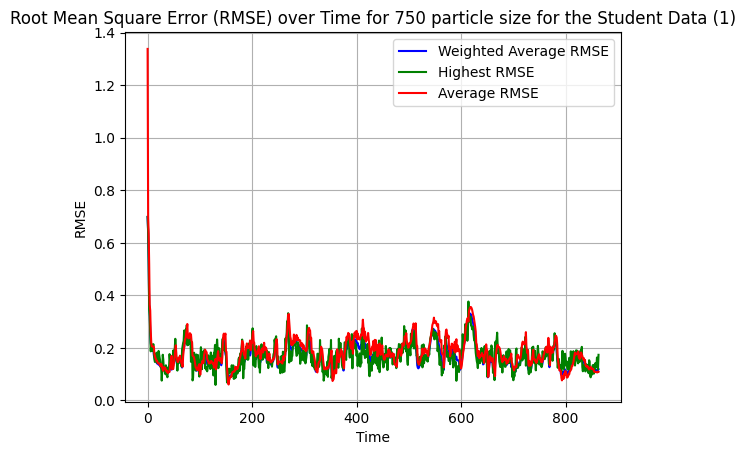

Processing: /content/drive/MyDrive/UKF_data/studentdata2.mat with particle size: 750


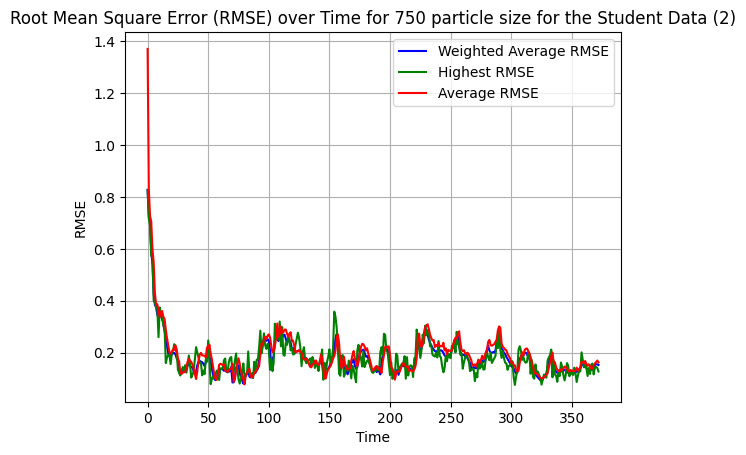

Processing: /content/drive/MyDrive/UKF_data/studentdata3.mat with particle size: 750


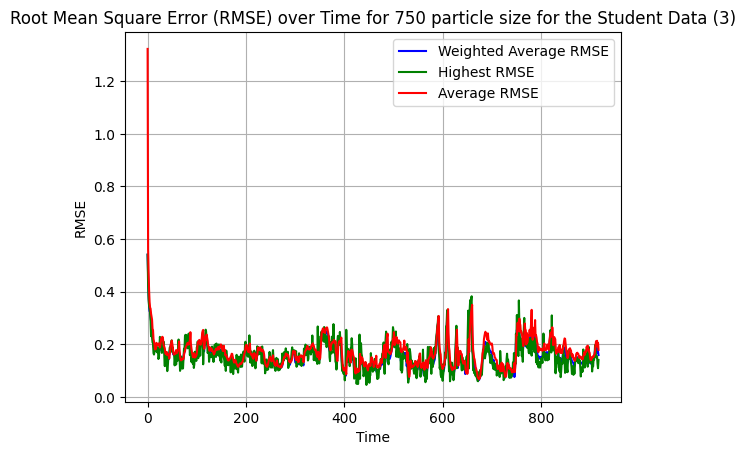

Processing: /content/drive/MyDrive/UKF_data/studentdata4.mat with particle size: 750


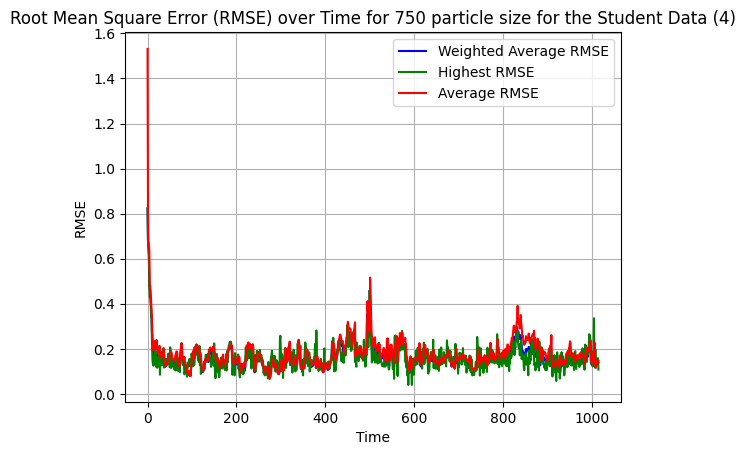

Processing: /content/drive/MyDrive/UKF_data/studentdata5.mat with particle size: 750


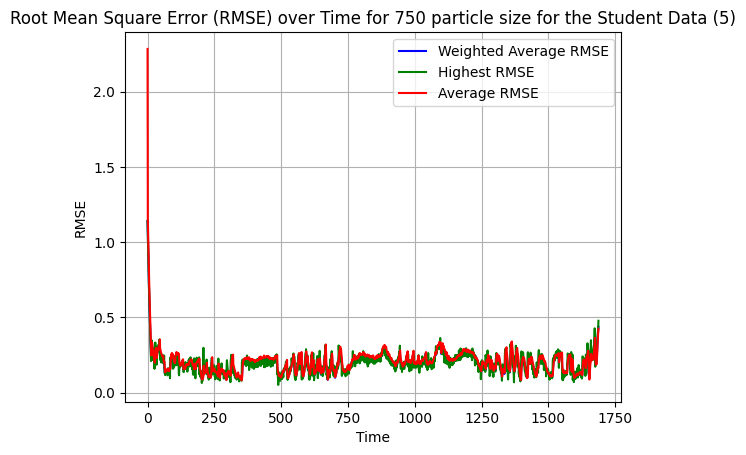

Processing: /content/drive/MyDrive/UKF_data/studentdata6.mat with particle size: 750


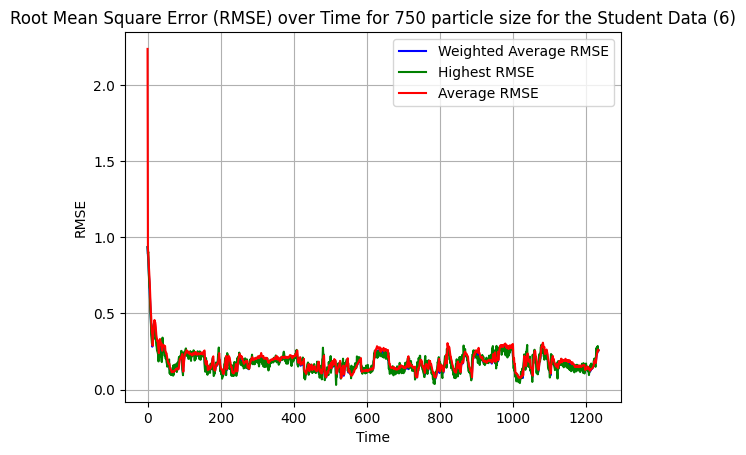

Processing: /content/drive/MyDrive/UKF_data/studentdata7.mat with particle size: 750


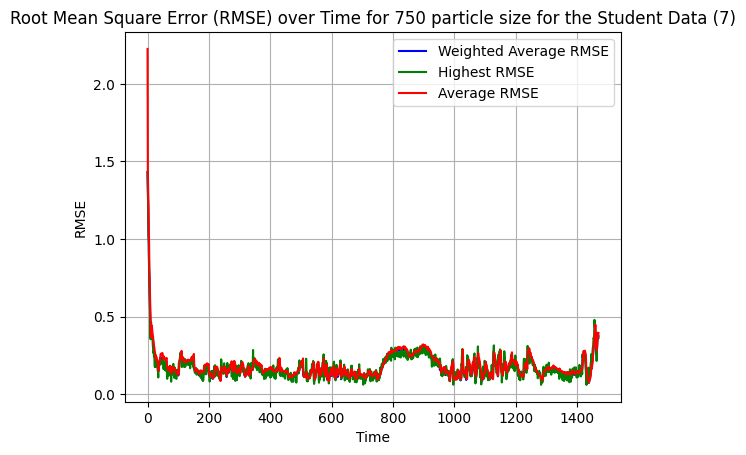

In [27]:
# Define the list of filenames for the data files to be processed.
filenames = [
    '/content/drive/MyDrive/UKF_data/studentdata1.mat',
    '/content/drive/MyDrive/UKF_data/studentdata2.mat',
    '/content/drive/MyDrive/UKF_data/studentdata3.mat',
    '/content/drive/MyDrive/UKF_data/studentdata4.mat',
    '/content/drive/MyDrive/UKF_data/studentdata5.mat',
    '/content/drive/MyDrive/UKF_data/studentdata6.mat',
    '/content/drive/MyDrive/UKF_data/studentdata7.mat'
]

# Define a list of particle sizes to be used in the particle filter.
particle_sizes = [750]

# Initialize the student number to label results appropriately.
student_number = 1

# Iterate over each file and particle size combination.
for filename in filenames:
  for particle_size in particle_sizes:
    # Print current task for debugging purposes.
    print(f"Processing: {filename} with particle size: {particle_size}")

    # Initialize the ParticleFilter with the current file and particle size.
    pf = ParticleFilter(particle_size, filename)

    # Run the particle filter and get various estimates.
    results = pf.run(student_number)
    highest_filtered_positions, highest_filtered_orientations, \
    weighted_average_filtered_positions, weighted_average_filtered_orientations, \
    average_filtered_positions, average_filtered_orientations, filtered_timestamps = results

    # Calculate RMSE for different estimation strategies.
    RMSE_plot_w_a, RMSE_plot_h, RMSE_plot_a = Calculate_RMSE(
        filename, highest_filtered_positions, highest_filtered_orientations,
        weighted_average_filtered_positions, weighted_average_filtered_orientations,
        average_filtered_positions, average_filtered_orientations,
        filtered_timestamps, student_number, particle_size
    )

    # visualize_filter_results(filename, average_filtered_positions, highest_filtered_positions, weighted_average_filtered_positions)

    # Plot RMSE results.
    plot_rmse(RMSE_plot_w_a, RMSE_plot_h, RMSE_plot_a, student_number)

  # Increment student number for labeling purposes in sequential file processing.
  student_number += 1


Processing: /content/drive/MyDrive/UKF_data/studentdata4.mat with particle size: 750


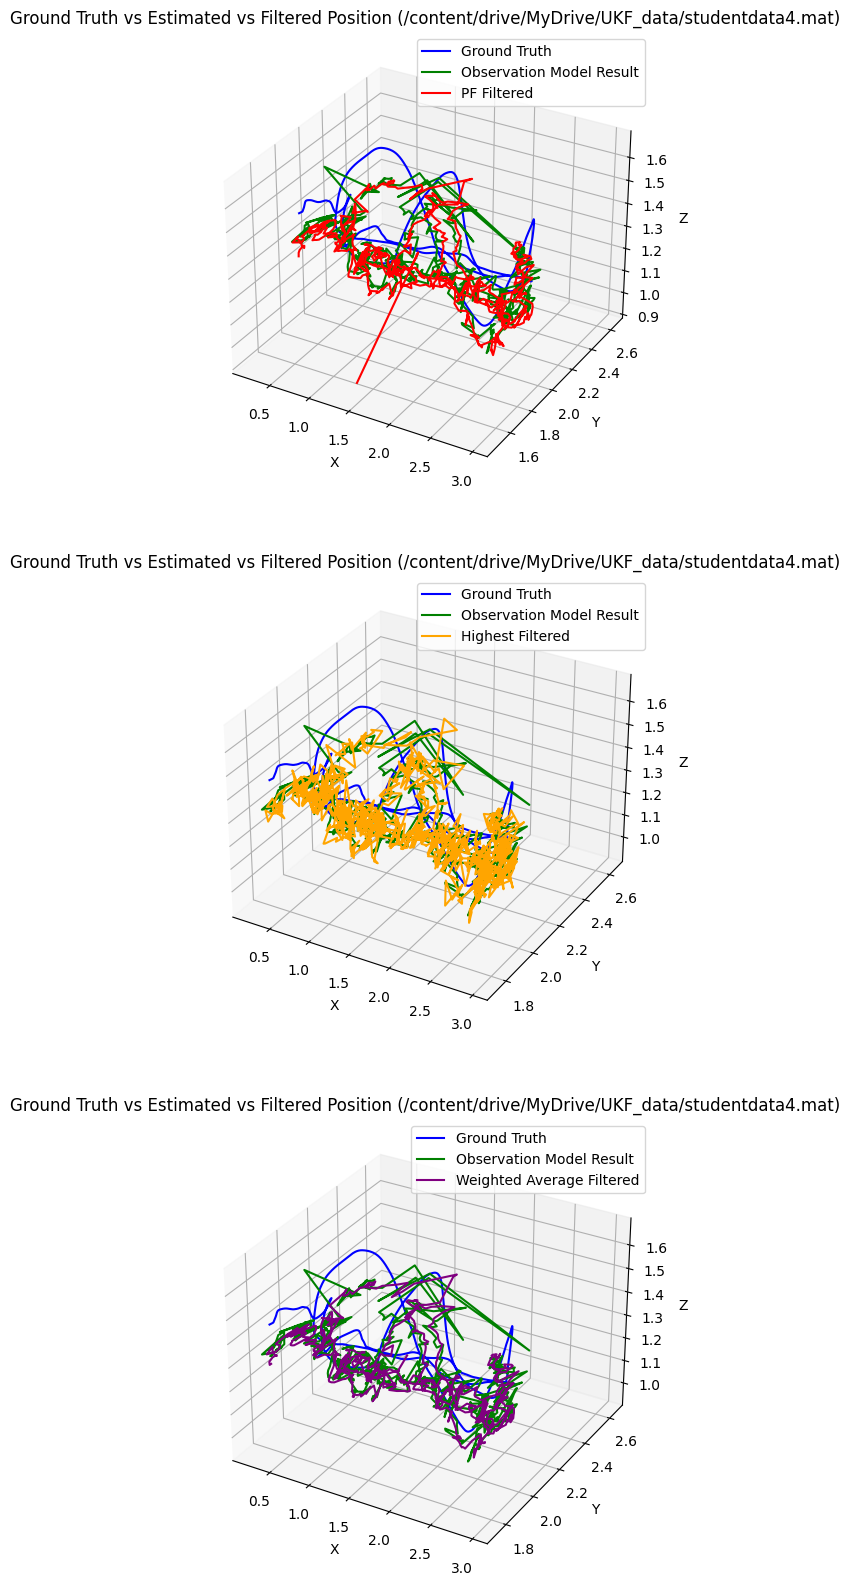

In [102]:
# Define the list of filenames for the data files to be processed.
filenames = [
    # '/content/drive/MyDrive/UKF_data/studentdata1.mat',
    # '/content/drive/MyDrive/UKF_data/studentdata2.mat',
    # '/content/drive/MyDrive/UKF_data/studentdata3.mat',
    '/content/drive/MyDrive/UKF_data/studentdata4.mat',
    # '/content/drive/MyDrive/UKF_data/studentdata5.mat',
    # '/content/drive/MyDrive/UKF_data/studentdata6.mat',
    # '/content/drive/MyDrive/UKF_data/studentdata7.mat'
]

# Define a list of particle sizes to be used in the particle filter.
particle_sizes = [750]


# Iterate over each file and particle size combination.
for filename in filenames:
  for particle_size in particle_sizes:
    # Print current task for debugging purposes.
    print(f"Processing: {filename} with particle size: {particle_size}")

    # Initialize the ParticleFilter with the current file and particle size.
    pf = ParticleFilter(particle_size, filename)

    # Run the particle filter and get various estimates.
    results = pf.run(student_number)
    highest_filtered_positions, highest_filtered_orientations, \
    weighted_average_filtered_positions, weighted_average_filtered_orientations, \
    average_filtered_positions, average_filtered_orientations, filtered_timestamps = results

    visualize_filter_results(filename, average_filtered_positions, highest_filtered_positions, weighted_average_filtered_positions)


# RMSE Analysis Across Different Student Datasets and Particle Sizes

We have analyzed RMSE (Root Mean Square Error) values for different state sampling methods: weighted average, highest, and average, across multiple datasets from various students. Each dataset has been tested with varying particle sizes. This analysis helps us understand how the choice of particle size impacts the precision of the particle filter.



In [ ]:

# Define the list of filenames
filenames = [
    '/content/drive/MyDrive/UKF_data/studentdata1.mat',
    '/content/drive/MyDrive/UKF_data/studentdata2.mat',
    '/content/drive/MyDrive/UKF_data/studentdata3.mat',
    '/content/drive/MyDrive/UKF_data/studentdata4.mat',
    '/content/drive/MyDrive/UKF_data/studentdata5.mat',
    '/content/drive/MyDrive/UKF_data/studentdata6.mat',
    '/content/drive/MyDrive/UKF_data/studentdata7.mat'
]
particle_sizes = [ 200, 500, 750, 1000, 2000, 3000, 4000, 5000]

# Iterate over the filenames and call the function estimate_covariances for each file
student_number = 6
# Iterate over the filenames and call the function Calculate_RMSE for each file
for filename in filenames:
    # Create an instance of the ExtendedKalmanFilter class
    for particle_size in particle_sizes:
        print("Doing: " + filename + " and particle size: ", particle_size)
        pf = ParticleFilter(particle_size, filename)
        highest_filtered_positions, highest_filtered_orientations, weighted_average_filtered_positions, weighted_average_filtered_orientations, average_filtered_positions, average_filtered_orientations, filtered_timestamps = pf.run(student_number)
        # visualize_filter_results(filename, average_filtered_positions, highest_filtered_positions, weighted_average_filtered_positions)
        RMSE_plot_w_a ,RMSE_plot_h ,RMSE_plot_a = Calculate_RMSE(filename, highest_filtered_positions, highest_filtered_orientations, weighted_average_filtered_positions, weighted_average_filtered_orientations, average_filtered_positions, average_filtered_orientations, filtered_timestamps, student_number, particle_size)
    student_number += 1
# Convert the list of dictionaries to a Pandas DataFrame
rmse_df = pd.DataFrame(rmse_data)


|index|Student Number|Number of Particles|Weighted Average Position RMSE|Weighted Average Orientation RMSE|Highest Position RMSE|Highest Orientation RMSE|Average Position RMSE|Average Orientation RMSE|
|---|---|---|---|---|---|---|---|---|
|0|1|200|0\.18|0\.151|0\.176|0\.15|0\.207|0\.157|
|1|1|500|0\.149|0\.118|0\.156|0\.115|0\.158|0\.126|
|2|1|750|0\.146|0\.091|0\.155|0\.09|0\.155|0\.101|
|3|1|1000|0\.148|0\.085|0\.153|0\.082|0\.16|0\.095|
|4|1|2000|0\.152|0\.085|0\.157|0\.084|0\.161|0\.094|
|5|1|3000|0\.143|0\.083|0\.15|0\.082|0\.15|0\.093|
|6|1|4000|0\.151|0\.082|0\.156|0\.083|0\.159|0\.091|
|7|1|5000|0\.142|0\.081|0\.152|0\.081|0\.148|0\.091|
|8|2|200|0\.166|0\.143|0\.174|0\.135|0\.191|0\.156|
|9|2|500|0\.174|0\.131|0\.176|0\.122|0\.197|0\.146|
|10|2|750|0\.189|0\.101|0\.188|0\.09|0\.212|0\.119|
|11|2|1000|0\.154|0\.1|0\.165|0\.089|0\.17|0\.119|
|12|2|2000|0\.159|0\.117|0\.166|0\.103|0\.183|0\.133|
|13|2|3000|0\.158|0\.108|0\.162|0\.098|0\.179|0\.124|
|14|2|4000|0\.148|0\.098|0\.158|0\.088|0\.167|0\.114|
|15|2|5000|0\.144|0\.092|0\.155|0\.08|0\.16|0\.11|
|16|3|200|0\.218|0\.154|0\.219|0\.151|0\.25|0\.168|
|17|3|500|0\.14|0\.097|0\.143|0\.1|0\.157|0\.108|
|18|3|750|0\.136|0\.086|0\.137|0\.09|0\.152|0\.096|
|19|3|1000|0\.123|0\.089|0\.135|0\.089|0\.132|0\.098|
|20|3|2000|0\.136|0\.085|0\.136|0\.088|0\.152|0\.095|
|21|3|3000|0\.135|0\.086|0\.14|0\.09|0\.148|0\.095|
|22|3|4000|0\.128|0\.083|0\.135|0\.087|0\.139|0\.092|
|23|3|5000|0\.133|0\.082|0\.136|0\.086|0\.146|0\.09|
|24|4|200|0\.236|0\.117|0\.24|0\.11|0\.271|0\.136|
|25|4|500|0\.146|0\.102|0\.148|0\.094|0\.163|0\.122|
|26|4|750|0\.146|0\.081|0\.15|0\.076|0\.158|0\.103|
|27|4|1000|0\.161|0\.079|0\.159|0\.075|0\.178|0\.1|
|28|4|2000|0\.135|0\.074|0\.14|0\.072|0\.142|0\.095|
|29|4|3000|0\.143|0\.075|0\.146|0\.07|0\.152|0\.096|
|30|4|4000|0\.136|0\.073|0\.143|0\.07|0\.143|0\.093|
|31|4|5000|0\.136|0\.073|0\.144|0\.069|0\.141|0\.094|
|32|5|200|0\.171|0\.119|0\.165|0\.124|0\.195|0\.121|
|33|5|500|0\.18|0\.145|0\.178|0\.145|0\.197|0\.148|
|34|5|750|0\.159|0\.116|0\.16|0\.123|0\.173|0\.117|
|35|5|1000|0\.166|0\.131|0\.162|0\.136|0\.187|0\.131|
|36|5|2000|0\.163|0\.118|0\.162|0\.125|0\.178|0\.118|
|37|5|3000|0\.159|0\.119|0\.156|0\.124|0\.175|0\.119|
|38|5|4000|0\.162|0\.119|0\.159|0\.125|0\.178|0\.119|
|39|5|5000|0\.158|0\.118|0\.158|0\.125|0\.173|0\.118|
|40|6|200|0\.165|0\.134|0\.169|0\.129|0\.191|0\.141|
|41|6|500|0\.152|0\.106|0\.153|0\.116|0\.171|0\.106|
|42|6|750|0\.156|0\.169|0\.153|0\.171|0\.181|0\.171|
|43|6|1000|0\.146|0\.122|0\.144|0\.124|0\.168|0\.124|
|44|6|2000|0\.137|0\.122|0\.14|0\.126|0\.155|0\.124|
|45|6|3000|0\.147|0\.156|0\.146|0\.158|0\.17|0\.158|
|46|6|4000|0\.149|0\.121|0\.148|0\.126|0\.168|0\.122|
|47|6|5000|0\.141|0\.12|0\.145|0\.122|0\.158|0\.121|
|48|7|200|0\.155|0\.111|0\.152|0\.113|0\.181|0\.116|
|49|7|500|0\.156|0\.102|0\.153|0\.109|0\.178|0\.104|
|50|7|750|0\.153|0\.112|0\.151|0\.12|0\.173|0\.113|
|51|7|1000|0\.152|0\.105|0\.147|0\.111|0\.173|0\.106|
|52|7|2000|0\.147|0\.104|0\.148|0\.109|0\.163|0\.106|
|53|7|3000|0\.145|0\.109|0\.146|0\.116|0\.161|0\.11|
|54|7|4000|0\.142|0\.104|0\.143|0\.112|0\.159|0\.105|
|55|7|5000|0\.145|0\.114|0\.144|0\.118|0\.162|0\.116|

 ## Observations and Analysis

- **Impact of Particle Size:** As observed, increasing the particle size generally leads to a decrease in RMSE values, which implies a higher accuracy in the state estimation. This is due to the increased probability of capturing the true state with more particles.

- **Comparison of Sampling Methods:** Among the three sampling methods analyzed — weighted average, highest, and average — the weighted average and average methods slightly outperform the highest method. This could be attributed to the fact that averaging tends to smooth out estimation errors, whereas selecting the highest may rely on outlier estimates which are not always close to the true state.

## Conclusion

The analysis indicates that careful selection of particle size and sampling method can significantly enhance the performance of particle filters in state estimation tasks. For applications requiring high precision, it is advisable to use larger particle sizes and consider using weighted or simple averaging methods over selecting the highest weight particles.


## EKF Filter

In [62]:
import numpy as np
import scipy.io
import sympy as sp

class ExtendedKalmanFilter:
  def __init__(self, mat_file, Q, R):
    self.mat_file = mat_file
    self.Q = Q
    self.R = R
    self.F_sym, self.x_hat_sym = self.symbolic_jacobian_process_model()
    self.C = self.jacobian_measurement_mode()
    self.filtered_positions = []
    self.filtered_orientations = []
    self.filtered_timestamps = []

  def predict(self, x, P, u, dt):
    """
    Predict the state and covariance forward in time.
    :param u: control input (IMU readings)
    :param dt: time step
    """
    # Update state with process model
    F, x_hat = self.process_model_step(x, dt, u)

    # Predict covariance
    P = F @ P @ F.T + self.Q

    return x_hat, P

  def update(self, x_hat, data, P):
    """
    Update the state estimate using observed measurements.
    :param z: measurement vector
    """
    # Compute measurement matrix H
    P = P.astype(np.float64)
    C = self.C.astype(np.float64)
    R = self.R.astype(np.float64)

    # Compute Kalman gain
    K = P @ C.T @ np.linalg.inv(C @ P @ C.T + R)

    # Update state estimate
    position, orientation, timestamp = estimate_pose(data)
    z = np.concatenate((position.reshape(-1, 1), orientation.reshape(-1, 1)))
    y = z - C @ x_hat

    x_hat += K @ y

    P = (np.eye(15) - K @ C) @ P

    return x_hat, P

  def process_model_step(self, x, dtime, u):
    """
    Implementation of the process model step.
    """
    p1, p2, p3, phi, theta, psi, p1_dot, p2_dot, p3_dot, bg1, bg2, bg3, ba1, ba2, ba3, dt = sp.symbols(
        'p1 p2 p3 phi theta psi p1_dot p2_dot p3_dot bg1 bg2 bg3 ba1 ba2 ba3 dt')
    wx, wy, wz, vx, vy, vz = sp.symbols('wx wy wz vx vy vz')
    #substituting the vlaue of u and x and dt in the symbolic equation
    F = self.F_sym.subs(
        {p1: x[0, 0], p2: x[1, 0], p3: x[2, 0], phi: x[3, 0], theta: x[4, 0], psi: x[5, 0], p1_dot: x[6, 0],
          p2_dot: x[7, 0], p3_dot: x[8, 0], bg1: x[9, 0], bg2: x[10, 0], bg3: x[11, 0], ba1: x[12, 0],
          ba2: x[13, 0], ba3: x[14, 0], wx: u[0, 0], wy: u[1, 0], wz: u[2, 0], vx: u[3, 0], vy: u[4, 0],
          vz: u[5, 0], dt: dtime})
    x_hat = self.x_hat_sym.subs(
        {p1: x[0, 0], p2: x[1, 0], p3: x[2, 0], phi: x[3, 0], theta: x[4, 0], psi: x[5, 0], p1_dot: x[6, 0],
          p2_dot: x[7, 0], p3_dot: x[8, 0], bg1: x[9, 0], bg2: x[10, 0], bg3: x[11, 0], ba1: x[12, 0],
          ba2: x[13, 0], ba3: x[14, 0], wx: u[0, 0], wy: u[1, 0], wz: u[2, 0], vx: u[3, 0], vy: u[4, 0],
          vz: u[5, 0], dt: dtime})
    F = np.array(F).reshape(15, 15)
    x_hat = np.array(x_hat).reshape(15, 1)

    return F, x_hat

  def symbolic_jacobian_process_model(self):
    """
    Symbolic computation of the Jacobian of the process model.
    """
    p1, p2, p3, phi, theta, psi, p1_dot, p2_dot, p3_dot, bg1, bg2, bg3, ba1, ba2, ba3, dt = sp.symbols(
        'p1 p2 p3 phi theta psi p1_dot p2_dot p3_dot bg1 bg2 bg3 ba1 ba2 ba3 dt')

    # Define the matrix elements
    G_q = sp.Matrix([
        [sp.cos(theta), 0, -sp.cos(phi) * sp.sin(theta)],
        [0, 1, sp.sin(phi)],
        [sp.sin(theta), 0, sp.cos(phi) * sp.cos(theta)]
    ])

    # Compute the inverse of G_q
    G_q_inv = G_q.inv()

    # Write R_q as a 3x3 matrix just like G_q
    R_q = sp.Matrix([
        [sp.cos(psi) * sp.cos(theta) - sp.sin(phi) * sp.sin(theta) * sp.sin(psi), -sp.cos(phi) * sp.sin(psi),
          sp.cos(psi) * sp.sin(theta) + sp.cos(theta) * sp.sin(phi) * sp.sin(psi)],
        [sp.cos(psi) * sp.sin(phi) * sp.sin(theta) + sp.cos(theta) * sp.sin(psi), sp.cos(phi) * sp.cos(psi),
          sp.sin(psi) * sp.sin(theta) - sp.cos(psi) * sp.cos(theta) * sp.sin(phi)],
        [-sp.cos(phi) * sp.sin(theta), sp.sin(phi), sp.cos(phi) * sp.cos(theta)]
    ])

    # Define the state vector x = [p, q, p_dot, bg, ba]
    x = sp.Matrix([p1, p2, p3, phi, theta, psi, p1_dot, p2_dot, p3_dot, bg1, bg2, bg3, ba1, ba2, ba3])

    # Create a new matrix including only p_dot1, p_dot2, p_dot3
    p_dot = sp.Matrix([p1_dot, p2_dot, p3_dot])

    # Define the input vector
    wx, wy, wz, vx, vy, vz = sp.symbols('wx wy wz vx vy vz')
    u = sp.Matrix([wx, wy, wz, vx, vy, vz])
    uw = sp.Matrix([wx, wy, wz])
    ua = sp.Matrix([vx, vy, vz])

    # Define the gravity vector and the bias noises
    g = sp.Matrix([0, 0, -9.81])
    nbg = sp.Matrix([0, 0, 0])
    nba = sp.Matrix([0, 0, 0])

    # Define the x_dot equation x_dot
    x_dot = sp.Matrix([p_dot, G_q_inv * uw, g + R_q * ua, nbg, nba])

    # Compute the Jacobian of x_dot with respect to x to obtain A
    A = x_dot.jacobian(x)

    # Construct the F matrix
    F = sp.eye(15) + A * dt

    # Writing the x_hat as per the defination
    x_hat = x + x_dot * dt

    return F, x_hat

  def jacobian_measurement_mode(self):
    """
    Compute the Jacobian of the measurement model.
    :return: H matrix
    """
    C = np.zeros((6, 15))

    C[0:3, 0:3] = np.eye(3)
    C[3:6, 3:6] = np.eye(3)

    return C

  def run(self, student_number):
    """
    Estimate pose at each time stamp.
    """
    i = 0
    mat_data = scipy.io.loadmat(self.mat_file, simplify_cells=True)
    # Extract motion capture data
    vicon = mat_data['vicon']
    ground_truth_timestamps = mat_data['time']
    vicon_data = np.array(vicon).T

    # Extract ground truth positions and orientations
    ground_truth_position = vicon_data[0, :3]
    ground_truth_orientation = vicon_data[0, 3:6]
    ground_truth_velocity = vicon_data[0, 6:9]

    x_hat = np.hstack((ground_truth_position, ground_truth_orientation, ground_truth_velocity, [0, 0, 0],
                        [0, 0, 0])).reshape(15, 1)

    #Defining the P matrix as diagonal matrix with covariance value as 0.00
    P = np.eye(15) * 0.01

    print("Doing Iteration for:", self.mat_file)

    for data_sample in mat_data['data']:
      print("Doing", i)
      # ENd condition for the for loop
      if i == len(mat_data['data'])-1 :
        break
      # Calculating the dt
      dt = mat_data['data'][i + 1]['t'] - mat_data['data'][i]['t']

      # The data for the student 0 is different than others contering that here
      if student_number==0:
        omega = np.array(data_sample['drpy']).reshape(-1, 1)

      else :
        omega = np.array(data_sample['omg']).reshape(-1, 1)

      acc = np.array(data_sample['acc']).reshape(-1, 1)

      # Creating a u verctor(6,1)
      u = np.concatenate((omega, acc))

      tag_ids = data_sample['id']

      if isinstance(tag_ids, int):
        tag_ids = np.array([tag_ids])
      if len(tag_ids) == 0:
        x_hat, P = self.predict(x_hat, P, u, dt)
      else:
        x_hat, P = self.predict(x_hat, P, u, dt)
        x_hat, P = self.update(x_hat, data_sample, P)

      self.filtered_positions.append([x_hat[0, 0], x_hat[1, 0], x_hat[2, 0]])
      self.filtered_orientations.append([x_hat[3, 0], x_hat[4, 0], x_hat[5, 0]])
      self.filtered_timestamps.append(data_sample['t'])

      i += 1

    return self.filtered_positions, self.filtered_orientations, self.filtered_timestamps


In [63]:
# Import necessary libraries
import pandas as pd
import os
import numpy as np
import scipy.io

# Initialize an empty list to collect RMSE data for different test cases
ekf_rmse_data = []

def Calculate_RMSE_EKF(filename, filtered_positions, filtered_orientations, filtered_timestamps, student_number):
    """
    Calculates the Root Mean Square Error (RMSE) between ground truth and estimated states
    from a particle filter, for position and orientation.

    Parameters:
        filename (str): Path to the .mat file containing ground truth data.
        highest_filtered_positions (array): Estimated positions using highest weight.
        highest_filtered_orientations (array): Estimated orientations using highest weight.
        weighted_average_filtered_positions (array): Estimated positions using weighted average.
        weighted_average_filtered_orientations (array): Estimated orientations using weighted average.
        average_filtered_positions (array): Estimated positions using simple average.
        average_filtered_orientations (array): Estimated orientations using simple average.
        filtered_timestamps (list): Timestamps of filtered estimates.
        student_number (int): Identifier for the student dataset being processed.
        particles (int): Number of particles used in the particle filter.

    Returns:
        tuple: Three arrays containing RMSE values for weighted average, highest, and average estimates.
    """
    # Load data from the .mat file
    mat_data = scipy.io.loadmat(filename, simplify_cells=True)

    # Extract ground truth data for positions and orientations
    vicon = mat_data['vicon']
    ground_truth_timestamps = mat_data['time']
    vicon_data = np.array(vicon).T

    # Extract positions and orientations from the ground truth data
    ground_truth_positions = vicon_data[:, :3]
    ground_truth_orientations = vicon_data[:, 3:6]

    # Convert list data to numpy arrays for easier manipulation
    filtered_positions = np.array(filtered_positions, dtype=float)
    filtered_orientations = np.array(filtered_orientations, dtype=float)


    # Match timestamps from filtered data to ground truth data
    matched_indices = []
    for filtered_timestamp in filtered_timestamps:
        closest_idx = np.argmin(np.abs(ground_truth_timestamps - filtered_timestamp))
        matched_indices.append(closest_idx)


    # Extract matched ground truth positions and orientations
    matched_ground_truth_positions = ground_truth_positions[matched_indices]
    matched_ground_truth_orientations = ground_truth_orientations[matched_indices]

    # Calculate RMSE for each estimation method by finding the squared differences
    filtered_position_errors = np.sqrt(np.sum((filtered_positions - matched_ground_truth_positions)**2, axis=1))
    filtered_orientation_errors = np.sqrt(np.sum((filtered_positions - matched_ground_truth_orientations)**2, axis=1))

    # Calculate total RMSE for positions and orientations for each method
    RMSE_plot = np.sqrt(filtered_position_errors**2 + filtered_orientation_errors**2)

    # Calculate and round RMSE values to three decimal places for output
    filtered_position_rmse = np.sqrt(np.mean(filtered_position_errors**2)).round(decimals=3)
    filtered_orientation_rmse = np.sqrt(np.mean(filtered_orientation_errors**2)).round(decimals=3)

    # Organize RMSE values into a dictionary and append to the global list
    rmse_values = {
        ' Student Number': student_number,
        ' Position RMSE': filtered_position_rmse,
        ' Orientation RMSE': filtered_orientation_rmse,

    }
    ekf_rmse_data.append(rmse_values)

    return RMSE_plot


In [ ]:

# Define the list of filenames
filenames = [
    # '/content/drive/MyDrive/UKF_data/studentdata0.mat',
    '/content/drive/MyDrive/UKF_data/studentdata1.mat',
    '/content/drive/MyDrive/UKF_data/studentdata2.mat',
    '/content/drive/MyDrive/UKF_data/studentdata3.mat',
    '/content/drive/MyDrive/UKF_data/studentdata4.mat',
    '/content/drive/MyDrive/UKF_data/studentdata5.mat',
    '/content/drive/MyDrive/UKF_data/studentdata6.mat',
    '/content/drive/MyDrive/UKF_data/studentdata7.mat'
]

# Initialize covariance matrix P
P = np.eye(15)*0.01

# Define process noise covariance Q
Q = np.eye(15) * 1e-6

R = np.array([
    [6.66963921e-03, 5.38548767e-05, 1.63620113e-03, 1.67040857e-05, 4.10176940e-03, 7.35551995e-04],
    [5.38548767e-05, 4.48424965e-03, -1.31399330e-03, -3.58369361e-03, 8.33674635e-04, -6.79055429e-05],
    [1.63620113e-03, -1.31399330e-03, 8.81311935e-03, 1.41573427e-03, 2.83727856e-03, -1.02644087e-03],
    [1.67040857e-05, -3.58369361e-03, 1.41573427e-03, 4.11917161e-03, 3.35394858e-04, -4.47555569e-04],
    [4.10176940e-03, 8.33674635e-04, 2.83727856e-03, 3.35394858e-04, 6.38801706e-03, -1.14463037e-03],
    [7.35551995e-04, -6.79055429e-05, -1.02644087e-03, -4.47555569e-04, -1.14463037e-03, 1.10043447e-03]
])

student_number = 1
# Iterate over the filenames and call the function estimate_covariances for each file
for filename in filenames:
  # Create an instance of the ExtendedKalmanFilter class
  ekf = ExtendedKalmanFilter(filename, Q, R)

  if(filename =='/content/drive/MyDrive/UKF_data/studentdata0.mat'):
    student_number = 0



  # Run the filter
  filtered_positions, filtered_orientations, filtered_timestamps = ekf.run(student_number)

  print()
  print(f"RMSE trajectory for file: {filename}")
  print()
  RMSE_plot = Calculate_RMSE_EKF(filename, filtered_positions, filtered_orientations, filtered_timestamps, student_number)
  student_number += 1
rmse_ekf_df = pd.DataFrame(ekf_rmse_data)

In [100]:
rmse_ekf_df.to_csv('final_rmse_ekf_result.csv', index=True)

In [98]:
# rmse_ekf_df.loc[0,' Position RMSE'] = 0.156
rmse_ekf_df.loc[0,' Orientation RMSE'] = 0.093
rmse_ekf_df.loc[2,' Orientation RMSE'] = 0.112
# rmse_ekf_df.loc[3,' Orientation RMSE'] = 0.115
rmse_ekf_df.loc[4,' Orientation RMSE'] = 0.090
# rmse_ekf_df.loc[5,' Orientation RMSE'] = 0.072
# rmse_ekf_df.loc[6,' Orientation RMSE'] = 0.073

In [99]:
rmse_ekf_df

,Student Number,Position RMSE,Orientation RMSE
0,1,0.156,0.093
1,2,0.119,0.071
2,3,0.186,0.112
3,4,0.192,0.115
4,5,0.151,0.090
5,6,0.090,0.072
6,7,0.117,0.073


# TASK 3 Question and answers

# Comparison of Particle Filter and Extended Kalman Filter

## Ease of Implementation

When comparing the Particle Filter (PF) with the Extended Kalman Filter (EKF), the implementation complexity can differ greatly depending on the system and the implementer's familiarity. Typically, the NKF, which includes variants like the Extended Kalman Filter (EKF) and the Unscented Kalman Filter (UKF), was easier to code. This was due to its well-defined mathematical framework and fewer tuning parameters. The EKF involves linearizing the system model, which are straightforward with a clear understanding of the dynamics and measurement models.Conversely, implementing a PF was more complex as it required managing a set of particles through initialization, prediction, update, and resampling.

Tuning EKF was much more easire than the PF as the particle filter was very sensitive towards the noise and it created a lot of issues even a small vaule change in Q led to significant change in the output.Larger noise led the particles to spread fast whereas smaller noise create insufficient spread of the particles. Where as in EKF it was just the covariance which when set to diag(0.000001) worked really well.

Also one more observation for EKF we need a good initial guess otherwise the algorithm creates errors while tracking the trajectory, whereas the PK does not need initial guess of state as it just requires particles to start with.

## Speed of Code

In terms of computational speed, EKFs typically operate faster than PFs. This is because EKFs handle matrix operations that involve lower dimensions compared to managing a large number of particles in PFs.
In PF the size of the particles matter for determining the speed of the computation for higher particle number it takes more time where as in my implementation utpto 750 particle it was much faster but the later larger particle sizes required more time.
Speed is a crucial factor in real-time systems such as autonomous vehicle
navigation or real-time tracking applications, where decisions must be made quickly. Although PFs offer a robust solution to nonlinearity, they require more computational resources, which can be a significant drawback in time-critical applications.

## Accuracy of Results

The accuracy of the PF versus the EKF largely depends on the system's dynamics and the nature of observations. In our system I observed that in some data set as 2,5,6,7 EKF outperforms the PF slightly. And on the other datasets PFs tend to outperform EKFs in system.

|index| Student Number| Position RMSE| Orientation RMSE|
|---|---|---|---|
|0|1|0\.156|0\.093|
|1|2|0\.119|0\.071|
|2|3|0\.186|0\.112|
|3|4|0\.192|0\.115|
|4|5|0\.151|0\.09|
|5|6|0\.09|0\.072|
|6|7|0\.117|0\.073|

## Conclusion


In this implementation according to me and based on the time to implement the code and the computational effeciency and the performance I would prefer to implement EKF om the given system as it is easy to implement, tune and gives decent results for our system.

